In [1]:
import os
import logging

import pandas as pd
import numpy as np

import h5py
import threading
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

DEP_FEATURE_NAME = 'surf_temp_sqerror'
HDF_LOCK = threading.Lock()
DATE_PATTERN = 'date%Y%m%d'
TIME_PATTERN = 'time%H%M'
KEY_PATTERN = '/{}/{}'.format(DATE_PATTERN, TIME_PATTERN)
STORE_PATH = 'metro_error_data_pro_swe2018.h5'

# Reduce log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [2]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount', 'station_id']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = ['forecast_length'] + HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES
DEPENDENT_FEATURES = ['stn_{}'.format(f) for f in ['dew_point', 'surf_temp']]
ERROR_FEATURES = ['surf_temp_sqerror']

In [3]:

start_time = datetime(2018, 9, 29, 5)
end_time = datetime(2018, 3, 14, 14)

def define_SSE(df, dep_feature_name):
    if dep_feature_name == 'surf_temp_sqerror':
        df[dep_feature_name] = (df['surf_temp'] - df['stn_surf_temp']) ** 2

def store_path(store_name):
    cwd = os.getcwd()
    return os.path.join(cwd, '{}.h5'.format(store_name))

def truncate_time(time):
    return time.replace(minute=10*(time.minute//10), second=0, microsecond=0)

def read(valid_time):
    valid_time = truncate_time(valid_time)
    with HDF_LOCK:
        with pd.HDFStore(STORE_PATH, 'r') as store:
            key = valid_time.strftime(KEY_PATTERN)
            if key in store:
                return store.get(key)

def gather_training_data(start_time, end_time):
    print('gathering training data from {} until {}'.format(start_time, end_time))
    ref_time = start_time
    dfs = []
    dfs.append(read(ref_time))
    df = pd.concat(dfs)
    print('Training data memory usage: {}Mb'.format(df.memory_usage().sum() / 10**6))
    return df

def train_test_splitter(df):
    define_target_features(df, dep_feature_name=DEP_FEATURE_NAME)
    return model

df = gather_training_data(start_time, end_time)
df.head()

gathering training data from 2018-09-29 05:00:00 until 2018-03-14 14:00:00
Training data memory usage: 1.366039Mb


,AirTemp,DewPoint,RainPrecip,SnowPrecip,SnowPrecipAccumulated,WindSpeed,AirPressure,OctalCloudCoverage,PrecipAmount,station_id,...,sub_temp,air_temp,dew_point,water_amount,snow_sum,forecast_length,stn_surf_temp,stn_dew_point,radiation,shade
0,10.9,8.824256,0.0,-0.0,0.0,4.8,102630.0,0.0,0.0,1202,...,6.72,8.1,7.7,0.020,0.0,1,7.8,7.96,257.708954,0.0
1,10.8,7.854865,0.0,-0.0,0.0,6.0,102650.0,0.0,0.0,1202,...,6.59,8.6,6.9,0.014,0.0,2,10.5,10.26,572.579224,0.0
2,11.4,6.937371,0.0,-0.0,0.0,6.4,102670.0,1.0,0.0,1202,...,6.49,9.7,6.2,0.002,0.0,3,13.7,10.20,713.935120,0.0
3,12.0,6.071365,0.0,-0.0,0.0,6.8,102670.0,3.0,0.0,1202,...,6.42,10.7,5.5,0.000,0.0,4,16.4,8.80,783.778503,0.0
4,12.3,6.139616,0.0,-0.0,0.0,7.1,102659.0,3.0,0.0,1202,...,6.38,11.3,5.7,0.000,0.0,5,18.9,8.12,817.249634,0.0


In [4]:
for dep_feature_name in ERROR_FEATURES:
    # ['surf_temp_sqerror']:
    define_SSE(df, dep_feature_name=dep_feature_name)


included = np.array(df[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
rsi = {
    "data": df.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
    "target": df.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
}
X_train, X_test, y_train, y_test = train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)

mean = X_train.mean(axis=0)    
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std

In [6]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = y_test
y_pred = neigh.predict(X_test)

mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred)

(49.474457198886284, 2.6924426744730163)

Text(0, 0.5, 'Estimated surf_temp_sqerror')

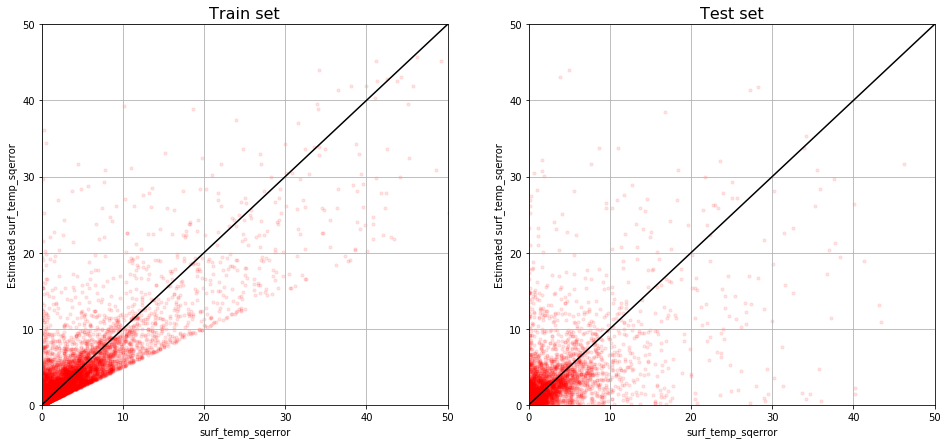

In [9]:
%matplotlib inline

from matplotlib import pyplot
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.subplot(121)
pyplot.scatter(y_train, neigh.predict(X_train), color="red", alpha=0.1, s=10)
pyplot.xlim(0,50)
pyplot.ylim(0,50)
pyplot.plot(range(60), color='black')
pyplot.grid()
pyplot.title('Train set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')

plt.subplot(122)
pyplot.scatter(y_test, neigh.predict(X_test), color="red", alpha=0.1, s=10)
pyplot.xlim(0,50)
pyplot.ylim(0,50)
pyplot.plot(range(60), color='black')
pyplot.grid()
pyplot.title('Test set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')